# Single Photo Resection

#### Welcome to this second exercise that explores Collinearity!

</style> 

<div class="alert alert-info"> <strong> NAME: </strong> [ write your name.surname between the brackets (like that name.surname) ]

</div> 

<img style="float:right;" src="./img/sensors001.png" width= 50% />

<br><br>

We have already seen that the **Collinearity equations** are a _vehicle_ that transform coordinates between an 3D object space ($X$, $Y$, $Z$) and an 2D image plane ($x$, $y$). 
<br>

This is essentially the foundation of photogrammetry and is crucial in 3D reconstruction, mapping, and computer vision tasks. 

We now extend this knowledge.
<!--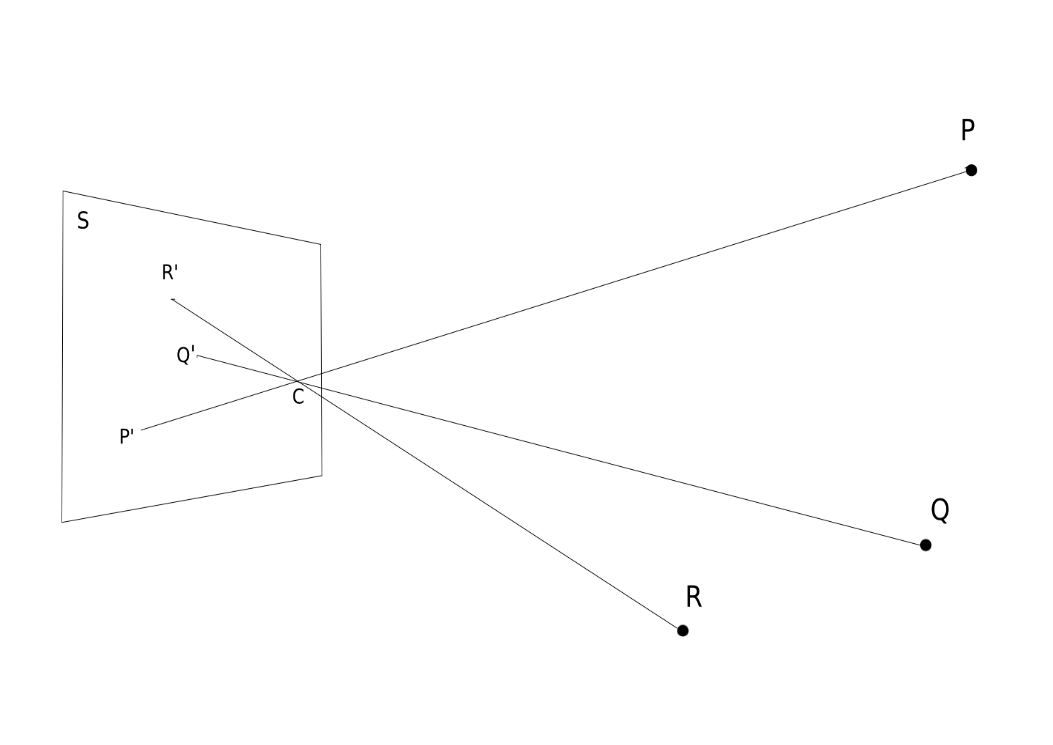-->


<div class="alert alert-block alert-success"> <strong> For this exercise we will solve the collinearity equation in its most basic form. </strong>  
    
A single photo resection through which we can determine the **parameteres of the camera**; namely its location ($X$, $Y$, and $Z$) and pose / orientation angles: omega ($\omega$), phi ($\phi$) and kappa ($\kappa$)).
<br><br>
A secondary focus is an opportunity to become familiar with the Python programming language and to experiment with changing functions, variables and parameters and to understand how these affect the result.
</div>
<!-- For this exercise we will solve the collinearity equation in its most basic form.-->

Given that, within the geospatial community, modern aerial photogrammery is often coupled with GNSS we already have a fairly good idea of these values. Our goal therefore is to **_refine and reduce uncertainty_**. 

Our inputs are:
- a camera file containing _the fiducial length along with GNSS derived parameters for the location and angles of rotation_; and
- a control point file with the _coordinate (x, y, z) values of known points and their respective (measured) image coordinates_.

For every measured point a set (of two) equations are obtained. If three control points are measured, a total of 6 equations is formed (a set of three) to solve for the 6 parameters of exterior orientation. **_i.e.: to solve the Collinearity equations we need a minimum of 6 known points per image!_**

<div class="alert alert-danger">
  <strong>REQUIRED!</strong> 
  
You are required to insert your outputs and any comment into this document. The document you submit should therefore contain the existing text in addition   
    
    

 - Plots and other outputs from exec the code
    nks
 - Discussion of your plots and other outputs as well as conclusions r. 
    hed.
 - This should also include any hypotheses and assumptions made as well as factors that may affect your conclusions.
</div>

In [57]:
#- load the magic
import sys
import numpy as np

from scipy.optimize import minimize
from scipy.optimize import leastsq

**Lets first look at what we have**

In [70]:
camera_file = './data/resec/camResc121.inp'
point_file = './data/resec/resecResc121.inp'

In [71]:
f = open(camera_file,'r')
with f:
    dat = np.loadtxt(f, float)

In [72]:
print ('Camera parameters:')
print ('GNSS: omega, ', dat[0])
print ('GNSS phi, ', dat[1])
print ('GNSS kappa, ', dat[2])
print ('GNSS X, ', dat[3])
print ('GNSS Y, ', dat[4])
print ('GNSS Z, ', dat[5])
print ('pp x, ', dat[6])
print ('pp y, ', dat[7])
print ('f, ', dat[8])

Camera parameters:
GNSS: omega,  -10.249468
GNSS phi,  1.084017
GNSS kappa,  -177.22678
GNSS X,  -49651.12
GNSS Y,  -3758661.65
GNSS Z,  139.83
pp x,  2737.24
pp y,  1839.91
f,  8.865


In [73]:
f = open(point_file) #'./data/resect.inp', 'r')
with f:
    rows = []
    for line in f:
        # Split on any whitespace (including tab characters)
        row = line.split()
        # Convert strings to numeric values:
        row[1] = float(row[1])
        row[2] = float(row[2])
        row[3] = float(row[3])
        row[4] = float(row[4])
        row[5] = float(row[5])
        # Append to our list of lists:
        rows.append(row)

print ('Control points with image (measured) and ground coordinates:')
print('[name, x, y, X, Y, Z]')
print(rows[0])
print(rows[1])
print(rows[2])
print(rows[3])
print(rows[4])

Control points with image (measured) and ground coordinates:
[name, x, y, X, Y, Z]
['6', 4499.249, 2934.776, -49678.88, -3758656.65, 85.02]
['7', 4457.987, 2125.049, -49678.57, -3758668.22, 85.36]
['8', 4327.378, 1480.602, -49676.92, -3758678.45, 85.22]
['4', 445.785, 1718.762, -49612.4, -3758673.17, 77.09]
['5', 2160.0, 1488.0, -49641.66, -3758678.98, 76.53]


<div class="alert alert-block alert-warning"><b>QUESTION! </b>  </div>

- **Why is it necessary to understand Collinearity?**

<div class="alert alert-block alert-info"><b>HINT!</b> What are we able to achieve through our knowledge of Collinearity? </div> 

{ click in this cell and write your answer here }

In [76]:
#_solving using scipy minimize_

#- adapted from author:  Jeffrey T. Walton, Paul Smith's College, New York. https://github.com/jeffwalton/photogrammetry-resection
# 
#   Single-photo resection - calculates the camera orientation and location
#       given camera calibration parameters, control point photo and world
#        coordinates and initial guesses for camera exterior orientation.
#
#   based on MATLAB code from:
#   Introduction to Modern Photogrammetry by Mikhail, Bethel, McGlone
#   John Wiley & Sons, Inc. 2001

def collinearity_eqn_residual(iop, eop, x, y, X, Y, Z):
    """
    Usage:
        collinearity_eqn_residual(iop, eop, x, y, X, Y, Z)

    Inputs:
        iop = dict of interior orientation parameters: x0, y0, f
        eop = dict of exterior orientation parameters: omega, phi, kappa, XL, YL, ZL
        x = array of x photo coordinates of control points
        y = array of y photo coordinates of control points
        X = array of X world coordinates of control points
        Y = array of Y world coordinates of control points
        Z = array of Z world coordinates of control points

    Returns:
        residuals in x and y collinearity equations for a single point as a tuple
    """
    from math import sin, cos
    x0 = iop['x0']
    y0 = iop['y0']
    focallength = iop['f']

    om = np.radians(eop['omega'])
    ph = np.radians(eop['phi'])
    kp = np.radians(eop['kappa'])

    XL = eop['XL']
    YL = eop['YL']
    ZL = eop['ZL']
    
    #- rotation matrix
    Mom = np.matrix([[1, 0, 0], [0, cos(om), sin(om)], [0, -sin(om), cos(om)]])
    Mph = np.matrix([[cos(ph), 0, -sin(ph)], [0, 1, 0], [sin(ph), 0, cos(ph)]])
    Mkp = np.matrix([[cos(kp), sin(kp), 0], [-sin(kp), cos(kp), 0], [0, 0, 1]])
    
    M = Mkp * Mph * Mom
    uvw = M * np.matrix([[X-XL], [Y-YL], [Z-ZL]])
    
    #- col. equ.
    px = (x0 - x)*0.00241     #-- from pixel to mm
    resx =  -(focallength * (uvw[0,0] / uvw[2,0])) + px 

    py = (y0 + y)*0.00241    #-- from pixel to mm
    resy =  -(focallength * (uvw[1,0] / uvw[2,0])) + py

    return resx, resy


class CollinearityData:
    """
    class to store data for the collinearity equations
    """
    def __init__(self, camera_file, point_file):
        """
        initilizes data for collinearity equations

        reads camera parameters from camera_file
        reads control point data from point_file
        """

        f = open(camera_file,'r')
        dat = np.loadtxt(f,float)
        f.close

        self.eop = {}

        # data from lines 1-3 of the camera_file
        self.eop['omega'] = dat[0]
        self.eop['phi'] = dat[1]
        self.eop['kappa'] = dat[2]

        # data from lines 4-6 of the camera_file
        self.eop['XL'] = dat[3]
        self.eop['YL'] = dat[4]
        self.eop['ZL'] = dat[5]
        
        self.iop = {}

        # data from lines 7-9 of the camera_file
        self.iop['x0'] = dat[6]
        self.iop['y0'] = dat[7]
        self.iop['f'] = dat[8]

        self.label = []
        x = []
        y = []
        X = []
        Y = []
        Z = []

        f = open(point_file,'r')
        for line in f:
            l = line.split()
            # each line has 6 values: label, x, y, X, Y, Z (whitespace delimited)
            self.label.append(l[0])
            x.append(float(l[1]))
            y.append(float(l[2]))
            X.append(float(l[3]))
            Y.append(float(l[4]))
            Z.append(float(l[5]))
        f.close

        self.x = np.array(x)
        self.y = np.array(y)
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)

        #-- comment out from here
        if self.eop['XL'] == 0 or self.eop['YL'] == 0 or self.eop['ZL'] == 0:
            ave_fheight = 100
            for i, j, k in zip(X, Y, Z):
                self.eop['XL'] += i
                self.eop['YL'] += j
                self.eop['ZL'] += k
            self.eop['XL'] /= len(x)
            self.eop['YL'] /= len(y)
            self.eop['ZL'] = sum(Z) / len(Z) + ave_fheight * dat[8]
        #-- comment out to here 

def coll_func(indep_vars):
    """
    collinearity function calculates a sum of the squared residuals of the collinearity equations for 
    all of the control points. This function is passed to scipy.optimize.minimize()

    Inputs:
        indep_vars (passed) are the exterior orientation parameters of the camera
        data (global) camera interior calibration data, photo points, control points

    Returns:
        sum of squared residuals of collinearity eqns
    """
    global data
    iop = data.iop
    #eop = data.eop
    label = data.label
    x = data.x
    y = data.y
    X = data.X
    Y = data.Y
    Z = data.Z

    eop = {}
    eop['omega'] = indep_vars[0]
    eop['phi'] = indep_vars[1]
    eop['kappa'] = indep_vars[2]
    eop['XL'] = indep_vars[3]
    eop['YL'] = indep_vars[4]
    eop['ZL'] = indep_vars[5]

    i = 0
    F = 0.0
    for l in label:
        F1, F2 = collinearity_eqn_residual(iop, eop, x[i], y[i], X[i], Y[i], Z[i])
        F += F1**2 + F2**2
        i += 1

    return F

data = CollinearityData(camera_file, point_file)

x0 = np.zeros(6)
# initilaize guesses for eop as read from file
eop = data.eop
x0[0] = eop['omega']
x0[1] = eop['phi']
x0[2] = eop['kappa']
x0[3] = eop['XL']
x0[4] = eop['YL']
x0[5] = eop['ZL']

#- unconstrained minimization: quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno (BFGS)
res = minimize(coll_func, x0, method='BFGS', options={'disp': True})

#print res.x
print('')
print('Solution:')
print('omega, ', res.x[0])
print('phi, ', res.x[1])
print('kappa, ', res.x[2])
print('XL, ', res.x[3])
print('YL, ', res.x[4])
print('ZL, ', res.x[5])

Optimization terminated successfully.
         Current function value: 0.352652
         Iterations: 58
         Function evaluations: 434
         Gradient evaluations: 62

Solution:
omega,  -3.787770740343843
phi,  4.445651342760188
kappa,  -181.77982141235427
XL,  -49648.325265373416
YL,  -3758730.3556062016
ZL,  147.11614225700762


<div class="alert alert-block alert-warning"><b>QUESTIONS! </b>  </div>


- **How do the calculated values compare with the initial values?**

{ click in this cell and write your answer here }

- **Are the initial GNSS values necessary? What would the result be if the GNSS values were zero?**

<div class="alert alert-block alert-info"><b>HINT!</b> 
    
</div> 
   
**Change the** `camera_file = ./data/resec/camResc121-0.inp.` 

**Discuss the result then look at:**  

    `#-- comment out from here... 
    
    ...#-- comment out to here` 
    
**Do what it says and observe the result. What is it doing? What is the nature of the collinearity equation?**

{ click in this cell and write your answer here }

- **How many collinearity equations were solved in this exercise**

<div class="alert alert-block alert-info"><b>HINT!</b> 5 (five) control points were measured. </div> 

{ click in this cell and write your answer here }

<div class="alert alert-block alert-warning"><b>BONUS MARKS! </b>  </div>

- **Use the knowledge from the `01transformation.ipynb` exercise and plot the 5 Ground Control Points on the** *DJI_0121.jpg* **in the** ./data/resec/ **folder.**

{ click in this cell. Change the type from `Markdown` to `Code` type your answer here. }

_images:_
    
- **World coordinate system and perspective projection camera coordinate system**: Kim, N.; Baek, S.; Kim, G. Absolute IOP/EOP Estimation Models without Initial Information of Various Smart City Sensors. Sensors 2023, 23, 742. https://doi.org/10.3390/s23020742